<a href="https://colab.research.google.com/github/tejash0901/DNA-Classification_RRCNN_LSTM/blob/main/RRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from Bio import SeqIO
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [ ]:
classesDict = {0: "MERS", 1: "SARS"}

attributes_list = []
classes_list = []
attrsSize = 0


In [ ]:
for key in classesDict:
    fasta_file = "/content/drive/MyDrive/data/sequences" + classesDict[key] + ".fasta"
    fasta_sequences = SeqIO.parse(open(fasta_file), 'fasta')

    for fasta in fasta_sequences:
        attributes_list.append(str(fasta.seq))
        classes_list.append(key)

    class_size = len(classes_list) - attrsSize
    print("class", classesDict[key], "size:", class_size)
    attrsSize = len(attributes_list)

attributes = np.array(attributes_list)
classes = np.array(classes_list)

print("total attributes size before oversampling:", attributes.shape[0])
print("total classes size before oversampling:", classes.shape[0])


class MERS size: 1453
class SARS size: 674
total attributes size before oversampling: 2127
total classes size before oversampling: 2127


In [ ]:
attributes = attributes.reshape(-1, 1)

oversampling_classes = {1: 1500}
sampler = SMOTEN(sampling_strategy=oversampling_classes, random_state=0)
X_res, y_res = sampler.fit_resample(attributes, classes)


/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (1500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1453)
  warnings.warn(


In [ ]:
maxSequence = 6000
X_resBinarized = np.zeros((len(X_res), maxSequence), dtype=np.uint8)
for i, sequence in enumerate(X_res):
    sequenceStr = sequence[0]
    sequenceBinarizedStr = ""
    index = 0
    for char in sequenceStr:
        if index < maxSequence:
            if char == 'a':
                sequenceBinarizedStr += "1"
            elif char == 'c':
                sequenceBinarizedStr += "2"
            elif char == 'g':
                sequenceBinarizedStr += "3"
            elif char == 't':
                sequenceBinarizedStr += "4"
            else:
                sequenceBinarizedStr += "0"
        index += 1

    if len(sequenceStr) < maxSequence:
        sequenceLength = len(sequenceStr)
        while sequenceLength < maxSequence:
            sequenceBinarizedStr += "0"
            sequenceLength += 1

    sequenceBinarized = np.array(list(sequenceBinarizedStr), dtype=np.uint8)
    X_resBinarized[i] = sequenceBinarized

x_train, x_test, y_train, y_test = train_test_split(X_resBinarized, y_res, test_size=0.3, random_state=4, stratify=y_res)

print("x_train size: ", x_train.shape[0])
print("y_train size: ", y_train.shape[0])
print("x_test size: ", x_test.shape[0])
print("y_test size: ", y_test.shape[0])

x_train size:  2067
y_train size:  2067
x_test size:  886
y_test size:  886


In [ ]:
batch_size = 32
num_classes = 5
epochs = 3
vocab_size = 5
embedding_dim = 8
maxlen = x_train.shape[1]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_test1 = np.argmax(y_test, axis=1)
y_train1 = np.argmax(y_train, axis=1)

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Add

# Input layer
inputs = Input(shape=(maxlen,))

# Embedding layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(inputs)

# Convolutional layers
conv1 = Conv1D(128, 2, activation='relu')(embedding)
pool1 = MaxPooling1D(pool_size=2)(conv1)

conv2 = Conv1D(64, 2, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)

# Residual connection
residual = Conv1D(64, 1)(pool2)  # 1x1 convolutional layer to match shapes
residual = residual[:, :pool2.shape[1], :]  # Slice the residual tensor to match pool2 shape

# LSTM layer
lstm_input = Add()([pool2, residual])
lstm = LSTM(64, return_sequences=True)(lstm_input)

# Flatten layer
flatten = Flatten()(lstm)

# Dense layers
dense1 = Dense(128, activation='relu')(flatten)
dense2 = Dense(64, activation='relu')(dense1)

# Output layer
outputs = Dense(num_classes, activation='softmax')(dense2)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Print the model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 6000)]       0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 6000, 8)      40          ['input_8[0][0]']                
                                                                                                  
 conv1d_35 (Conv1D)             (None, 5999, 128)    2176        ['embedding_9[0][0]']            
                                                                                                  
 max_pooling1d_16 (MaxPooling1D  (None, 2999, 128)   0           ['conv1d_35[0][0]']              
 )                                                                                          

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [ ]:
from keras.utils import to_categorical

# Convert target variable to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Epoch 1/3
65/65 [==============================] - 182s 3s/step - loss: 0.6917 - accuracy: 0.6913 - val_loss: 0.3498 - val_accuracy: 0.8826
Epoch 2/3
65/65 [==============================] - 177s 3s/step - loss: 0.2938 - accuracy: 0.8747 - val_loss: 0.2496 - val_accuracy: 0.8928
Epoch 3/3
65/65 [==============================] - 179s 3s/step - loss: 0.2316 - accuracy: 0.8902 - val_loss: 0.1881 - val_accuracy: 0.9142


In [ ]:
y_predicted = model.predict(x_test)
print("Prediction: ", y_predicted)


28/28 [==============================] - 19s 585ms/step
Prediction:  [[9.88540471e-01 1.12663349e-02 1.44583146e-05 8.09248959e-05
  9.77718882e-05]
 [9.85172331e-01 1.48049435e-02 3.93151822e-06 1.04246765e-05
  8.37794960e-06]
 [3.75422724e-06 9.99996245e-01 9.60304725e-09 1.45301582e-09
  2.95902303e-09]
 ...
 [9.87505317e-01 1.22817755e-02 1.58774055e-05 8.81408268e-05
  1.08734195e-04]
 [3.72044593e-01 6.27525747e-01 1.23271413e-04 1.64029989e-04
  1.42257253e-04]
 [3.75422769e-06 9.99996305e-01 9.60304725e-09 1.45301593e-09
  2.95902325e-09]]


In [ ]:
y_pred_labels = np.argmax(y_predicted, axis=1)

In [ ]:
y_pred_labels

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,

Confusion matrix
[[372  64]
 [ 12 438]]

Classification report
              precision    recall  f1-score   support

        Mers       0.97      0.85      0.91       436
        Sars       0.87      0.97      0.92       450

    accuracy                           0.91       886
   macro avg       0.92      0.91      0.91       886
weighted avg       0.92      0.91      0.91       886



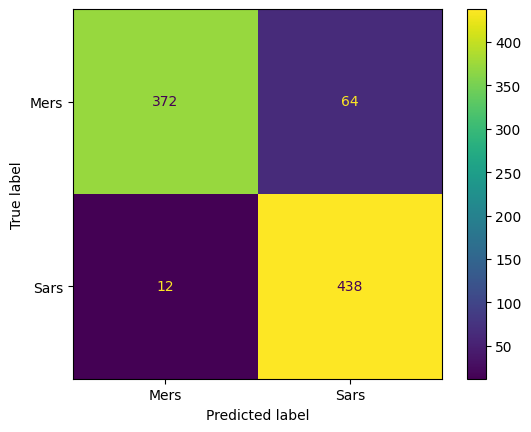

In [ ]:
from sklearn import metrics

print("Confusion matrix")
confusion_matrix = metrics.confusion_matrix(y_true=y_test1, y_pred=y_pred_labels)
print(confusion_matrix)
target_names = ['Mers', 'Sars']
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=target_names)
disp.plot()

print()
print("Classification report")
report = metrics.classification_report(y_test1, y_pred_labels, target_names=target_names)
print(report)


In [ ]:
model.save('model1.h5')
